# load the libraries

In [84]:
import numpy as np
import pandas as pd

import datetime as dt

import matplotlib.pyplot as plt

from matplotlib.dates import MO, WeekdayLocator, DateFormatter
%matplotlib inline

# Download a few turnstile data from http://web.mta.info/developers/turnstile.html and read them into a pandas dataframe 

In [2]:
## download files from MTA website
mta_url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_'
# define the start and end dates to acquire the data
date_fmt = '%y%m%d' 
end = '171028'
start = '170902'

# convert them into datetime objects
start_dt = dt.datetime.strptime(start, date_fmt)
end_dt = dt.datetime.strptime(end, date_fmt)

# get the turnstile data between these dates and write them to local directory
while start_dt<=end_dt:
    filename = start_dt.strftime(date_fmt)+'.txt'
    urlname = mta_url+filename 
    pd.read_csv(urlname).to_csv('turnstile_data/turnstile_'+filename, index=False)
    print('Writing file turnstile_data/turnstile_{}'.format(filename))
    #increment the date by 7 days for the next file
    start_dt += dt.timedelta(days=7)

Writing file turnstile_data/turnstile_170902.txt
Writing file turnstile_data/turnstile_170909.txt
Writing file turnstile_data/turnstile_170916.txt
Writing file turnstile_data/turnstile_170923.txt
Writing file turnstile_data/turnstile_170930.txt
Writing file turnstile_data/turnstile_171007.txt
Writing file turnstile_data/turnstile_171014.txt
Writing file turnstile_data/turnstile_171021.txt
Writing file turnstile_data/turnstile_171028.txt


In [2]:
# define the start and end dates to acquire the data
# taking one month data for this analysis
date_fmt = '%y%m%d' 
end = '171028'
start = '170902'

# convert them into datetime objects
start_dt = dt.datetime.strptime(start, date_fmt)
end_dt = dt.datetime.strptime(end, date_fmt)

# get the turnstile data between these dates
data_folder = 'turnstile_data/turnstile_'
turnstile_list = []
while start_dt<=end_dt:
    filename = data_folder+start_dt.strftime(date_fmt)+'.txt'   
    turnstile_list.append(pd.read_csv(filename))
    #increment the date by 7 days for the next file
    start_dt += dt.timedelta(days=7)

# concatenate all the dataframes
turnstile_df = pd.concat(turnstile_list, ignore_index=True)

# delete variables not needed
del turnstile_list[:] 

In [3]:
turnstile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781548 entries, 0 to 1781547
Data columns (total 11 columns):
C/A                                                                     object
UNIT                                                                    object
SCP                                                                     object
STATION                                                                 object
LINENAME                                                                object
DIVISION                                                                object
DATE                                                                    object
TIME                                                                    object
DESC                                                                    object
ENTRIES                                                                 int64
EXITS                                                                   int64
dtypes: int64(2), ob

# Clean the data

In [4]:
# remove blank spaces from column names
turnstile_df.rename(columns=lambda x:x.strip(), inplace=True)

In [5]:
# add a column which combines the DATE and TIME columns into a Pandas Datetime object
turnstile_df['DATETIME'] = pd.to_datetime(turnstile_df['DATE']+' '+turnstile_df['TIME'], 
                                       format='%m/%d/%Y %H:%M:%S')
turnstile_df['DATE'] = pd.to_datetime(turnstile_df['DATE'], 
                                       format='%m/%d/%Y').dt.date
turnstile_df['TIME'] = pd.to_datetime(turnstile_df['TIME'], 
                                       format='%H:%M:%S').dt.time

In [6]:
# Update the LINENAME column by sorting the line names so that different combinations are the same
turnstile_df['LINENAME'] = [''.join(sorted(lname)) for lname in turnstile_df['LINENAME']]
# strip any blank spaces from STATION name
turnstile_df['STATION'] = [station.strip() for station in turnstile_df['STATION']]
# create new station ID
turnstile_df['STATION_ID'] = turnstile_df['STATION']+'_'+turnstile_df['LINENAME']

In [7]:
# sort the turnstile dataframes
turnstile_df.sort_values(["STATION_ID", "C/A", "UNIT", "SCP", "DATETIME"], 
                          inplace=True, ascending=True)

In [8]:
turnstile_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME,STATION_ID
29220,H007,R248,00-00-00,1 AV,L,BMT,2017-08-26,00:00:00,REGULAR,12656485,14017760,2017-08-26 00:00:00,1 AV_L
29221,H007,R248,00-00-00,1 AV,L,BMT,2017-08-26,04:00:00,REGULAR,12656566,14018068,2017-08-26 04:00:00,1 AV_L
29222,H007,R248,00-00-00,1 AV,L,BMT,2017-08-26,08:00:00,REGULAR,12656649,14018379,2017-08-26 08:00:00,1 AV_L
29223,H007,R248,00-00-00,1 AV,L,BMT,2017-08-26,12:00:00,REGULAR,12657066,14019030,2017-08-26 12:00:00,1 AV_L
29224,H007,R248,00-00-00,1 AV,L,BMT,2017-08-26,16:00:00,REGULAR,12657715,14019973,2017-08-26 16:00:00,1 AV_L


In [9]:
print('Number of unique stations:', turnstile_df['STATION_ID'].nunique())

Number of unique stations: 468


In [10]:
# remove group 34 ST-PENN STA_123ACE since it doesn't exist
grp = turnstile_df.groupby('STATION_ID', as_index=False, sort=False)
turnstile_df.drop(grp.get_group('34 ST-PENN STA_123ACE').index, inplace=True)

In [11]:
print('Number of unique stations:', turnstile_df['STATION_ID'].nunique())

Number of unique stations: 467


In [12]:
# remove duplicate turnstile counts
key_columns = ['C/A', 'UNIT', 'SCP', 'STATION_ID', 'DATETIME']
turnstile_df.drop_duplicates(subset=key_columns, inplace=True)

In [13]:
# selecting one of the turnstile data
mask = ((turnstile_df['C/A']=='A002') & 
        (turnstile_df['UNIT']=='R051') & 
        (turnstile_df['SCP']=='02-00-00') & 
        (turnstile_df['STATION']=='59 ST') &
        (turnstile_df['LINENAME']=='456NQRW'))
# find the difference between consecutive date-times
time_diff = turnstile_df[mask]['DATETIME'].diff(1)
# get the mean time interval between two readings
time_diff.describe()

count                       380
mean     0 days 03:58:06.315789
std      0 days 00:17:57.820399
min             0 days 00:23:00
25%             0 days 04:00:00
50%             0 days 04:00:00
75%             0 days 04:00:00
max             0 days 04:00:00
Name: DATETIME, dtype: object

**The min, max, median and mean for this particular turnstile is 4 hours. Assuming similar behavior for all the turnstiles, the entry and exit counts are recorded every 4 hours.**

In [14]:
# check the times at which the counts are recorded
turnstile_df['TIME'].value_counts().sort_values(ascending=False).head()

04:00:00    152265
20:00:00    152261
00:00:00    152237
08:00:00    152216
16:00:00    152189
Name: TIME, dtype: int64

In [15]:
# check the times at which the counts are recorded
turnstile_df['TIME'].value_counts().sort_values(ascending=False).tail()

06:15:20    1
11:18:07    1
11:09:59    1
17:12:08    1
03:15:40    1
Name: TIME, dtype: int64

**It looks like some of the recordings were not on the hour and from the low counts it can be inferred that they were not intended to be recorded. We will remove those rows from the dataframe**

In [16]:
# discard rows which have readings not at the hour
turnstile_df = turnstile_df[turnstile_df['DATETIME'].dt.floor(freq='H')==turnstile_df['DATETIME']]

In [17]:
turnstile_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1614763 entries, 29220 to 1757545
Data columns (total 13 columns):
C/A           1614763 non-null object
UNIT          1614763 non-null object
SCP           1614763 non-null object
STATION       1614763 non-null object
LINENAME      1614763 non-null object
DIVISION      1614763 non-null object
DATE          1614763 non-null object
TIME          1614763 non-null object
DESC          1614763 non-null object
ENTRIES       1614763 non-null int64
EXITS         1614763 non-null int64
DATETIME      1614763 non-null datetime64[ns]
STATION_ID    1614763 non-null object
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 172.5+ MB


# Check the entry and exit counts

In [18]:
# selecting one of the turnstile data
mask = ((turnstile_df['C/A']=='A002') & 
        (turnstile_df['UNIT']=='R051') & 
        (turnstile_df['SCP']=='02-00-00') & 
        (turnstile_df['STATION']=='59 ST') &
        (turnstile_df['LINENAME']=='456NQRW'))

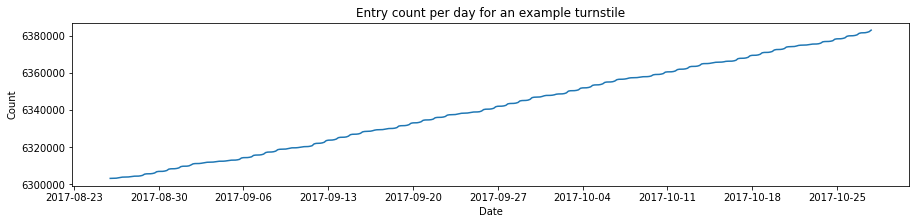

In [19]:
plt.figure(figsize=(15,3));
plt.plot(turnstile_df[mask]['DATETIME'], turnstile_df[mask]['ENTRIES']);
plt.xlabel('Date');
plt.ylabel('Count');
plt.title('Entry count per day for an example turnstile');

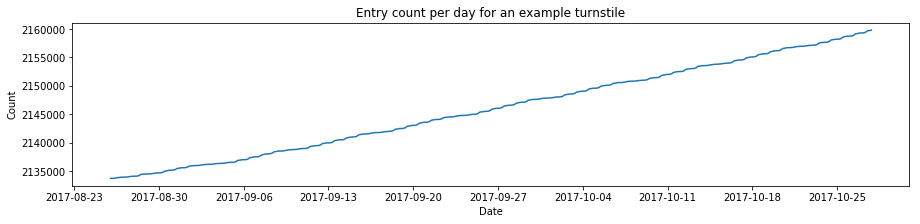

In [20]:
plt.figure(figsize=(15,3));
plt.plot(turnstile_df[mask]['DATETIME'], turnstile_df[mask]['EXITS']);
plt.xlabel('Date');
plt.ylabel('Count');
plt.title('Entry count per day for an example turnstile');

**From the above plots the ENTRIES (and EXITS) count increases with time. This shows that the ENTRIES (and EXITS) counts are cumulative ENTRY (and EXIT) register values for a device. This register was initialized during system setup.**

In [21]:
# columns which uniquely identify a turnstile
turnstile_key = ['C/A', 'UNIT', 'SCP', 'STATION_ID']
# group by turnstile and find the size of each group
turnstile_grp = turnstile_df.groupby(turnstile_key, as_index=False, sort=False)
# discard turnstiles which have less than 4 readings 
turnstile_df = turnstile_grp.filter(lambda x: len(x) >= 3)

In [22]:
# columns which uniquely identify a turnstile
turnstile_key = ['C/A', 'UNIT', 'SCP', 'STATION_ID']
# create a new column which holds the ENTRIES value at the previous timestamp
turnstile_df['PREV_ENTRIES'] = turnstile_df.groupby(turnstile_key, as_index=False, sort=False)['ENTRIES'].shift(1)
# create a new column which holds the EXITS value at the previous timestamp
turnstile_df['PREV_EXITS'] = turnstile_df.groupby(turnstile_key, as_index=False, sort=False)['EXITS'].shift(1)

/Users/sakina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/sakina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [23]:
# find rows where previous entry is not less than current entry
rev_mask = turnstile_df['ENTRIES']<turnstile_df['PREV_ENTRIES']
print('{} rows have the counter counting down for ENTRIES column'.format(rev_mask.sum()))

13752 rows have the counter counting down for ENTRIES column


# get the entry/exit count for each time interval

In [24]:
# function to get the entry count given the cumulative entry at current time and at previous time 
def getTurnstileCount(cumulative_tuple):
    current, previous = cumulative_tuple
    return abs(current - previous) # taking absolute value to account for counters counting down

In [25]:
# remove rows which have missing values in the PREV_ENTRIES caused by the shifting
turnstile_entry_df = turnstile_df.dropna(subset=['PREV_ENTRIES'])
# get the entry count for each time stamp
turnstile_entry_df['ENTRY_COUNT'] = turnstile_entry_df[['ENTRIES', 'PREV_ENTRIES']].\
                                    apply(getTurnstileCount, axis=1)

# set the cutoff value for the entry count to be the 99.9% quantile. Remove the rows containing outliers
q999_entry = turnstile_entry_df['ENTRY_COUNT'].quantile(0.999) # 99.9% quantile
turnstile_entry_df = turnstile_entry_df[turnstile_entry_df['ENTRY_COUNT']<=q999_entry].copy()

#delete columns
turnstile_entry_df.drop(['DIVISION', 'DESC', 'ENTRIES', 'PREV_ENTRIES', 'EXITS', 'PREV_EXITS'], axis=1, inplace=True)

turnstile_entry_df.head()

/Users/sakina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DATETIME,STATION_ID,ENTRY_COUNT
29221,H007,R248,00-00-00,1 AV,L,2017-08-26,04:00:00,2017-08-26 04:00:00,1 AV_L,81.0
29222,H007,R248,00-00-00,1 AV,L,2017-08-26,08:00:00,2017-08-26 08:00:00,1 AV_L,83.0
29223,H007,R248,00-00-00,1 AV,L,2017-08-26,12:00:00,2017-08-26 12:00:00,1 AV_L,417.0
29224,H007,R248,00-00-00,1 AV,L,2017-08-26,16:00:00,2017-08-26 16:00:00,1 AV_L,649.0
29225,H007,R248,00-00-00,1 AV,L,2017-08-26,20:00:00,2017-08-26 20:00:00,1 AV_L,428.0


In [26]:
# remove rows which have missing values in the PREV_EXITS caused by the shifting
turnstile_exit_df = turnstile_df.dropna(subset=['PREV_EXITS'])
# get the exit count for each time stamp
turnstile_exit_df['EXIT_COUNT'] = turnstile_exit_df[['EXITS', 'PREV_EXITS']].apply(getTurnstileCount, axis=1)

# set the cutoff value for the exit count to be the 99.9% quantile. Remove the rows containing outliers
q999_exit = turnstile_exit_df['EXIT_COUNT'].quantile(0.999) # 99.9% quantile
turnstile_exit_df = turnstile_exit_df[turnstile_exit_df['EXIT_COUNT']<=q999_exit] 

#delete columns
turnstile_exit_df.drop(['DIVISION', 'DESC', 'ENTRIES', 'PREV_ENTRIES', 'EXITS', 'PREV_EXITS'], axis=1, inplace=True)

turnstile_exit_df.head()

/Users/sakina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DATETIME,STATION_ID,EXIT_COUNT
29221,H007,R248,00-00-00,1 AV,L,2017-08-26,04:00:00,2017-08-26 04:00:00,1 AV_L,308.0
29222,H007,R248,00-00-00,1 AV,L,2017-08-26,08:00:00,2017-08-26 08:00:00,1 AV_L,311.0
29223,H007,R248,00-00-00,1 AV,L,2017-08-26,12:00:00,2017-08-26 12:00:00,1 AV_L,651.0
29224,H007,R248,00-00-00,1 AV,L,2017-08-26,16:00:00,2017-08-26 16:00:00,1 AV_L,943.0
29225,H007,R248,00-00-00,1 AV,L,2017-08-26,20:00:00,2017-08-26 20:00:00,1 AV_L,1061.0


In [27]:
(turnstile_df.shape, turnstile_entry_df.shape, turnstile_exit_df.shape)

((1614759, 15), (1608838, 10), (1608836, 10))

In [28]:
# combine the entry and exit count into one dataframe
turnstile_df = pd.concat([turnstile_entry_df, turnstile_exit_df['EXIT_COUNT']], axis=1, join='inner')

turnstile_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DATETIME,STATION_ID,ENTRY_COUNT,EXIT_COUNT
29221,H007,R248,00-00-00,1 AV,L,2017-08-26,04:00:00,2017-08-26 04:00:00,1 AV_L,81.0,308.0
29222,H007,R248,00-00-00,1 AV,L,2017-08-26,08:00:00,2017-08-26 08:00:00,1 AV_L,83.0,311.0
29223,H007,R248,00-00-00,1 AV,L,2017-08-26,12:00:00,2017-08-26 12:00:00,1 AV_L,417.0,651.0
29224,H007,R248,00-00-00,1 AV,L,2017-08-26,16:00:00,2017-08-26 16:00:00,1 AV_L,649.0,943.0
29225,H007,R248,00-00-00,1 AV,L,2017-08-26,20:00:00,2017-08-26 20:00:00,1 AV_L,428.0,1061.0


# look at the daily entry/exit trend for a station

In [29]:
# find the daily entry count for each station across the whole timeframe
station_key = ['STATION_ID', 'DATE']
station_daily_df = (turnstile_df.groupby(station_key, sort=False, as_index=False)
                    [['ENTRY_COUNT', 'EXIT_COUNT']].agg('sum'))
station_daily_df.rename(columns={'ENTRY_COUNT':'DAILY_ENTRY_COUNT',
                                 'EXIT_COUNT' :'DAILY_EXIT_COUNT'}, inplace=True)
# choose a station
df = station_daily_df[station_daily_df['STATION_ID']=='GRD CNTRL-42 ST_4567S']

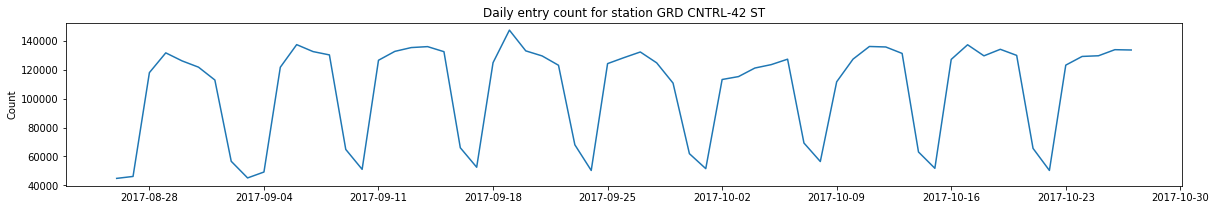

In [30]:
# plotting the daily entry counts for 1 station
fig, ax = plt.subplots(1,1, figsize=(20,3))
ax.plot(df['DATE'], df['DAILY_ENTRY_COUNT']);
ax.set_title('Daily entry count for station GRD CNTRL-42 ST');
ax.set_ylabel('Count');
ax.xaxis.set_major_locator(WeekdayLocator(byweekday=MO))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
#fig.savefig('Daily Entries GrndCtrl.png', bbox_inches='tight')

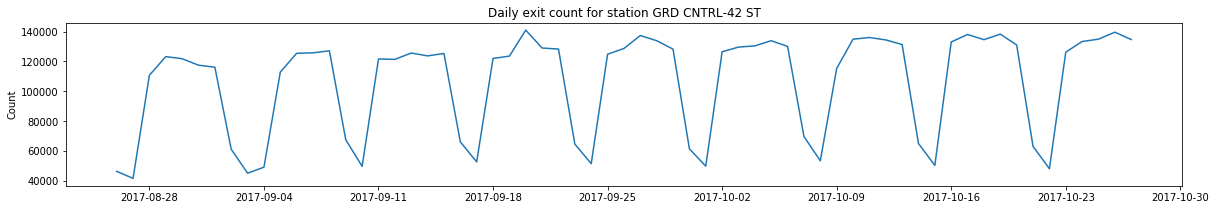

In [31]:
# plotting the daily exit counts for 1 station
fig, ax = plt.subplots(1,1, figsize=(20,3))
ax.plot(df['DATE'], df['DAILY_EXIT_COUNT']);
ax.set_title('Daily exit count for station GRD CNTRL-42 ST');
ax.set_ylabel('Count');
ax.xaxis.set_major_locator(WeekdayLocator(byweekday=MO))
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))

/Users/sakina/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


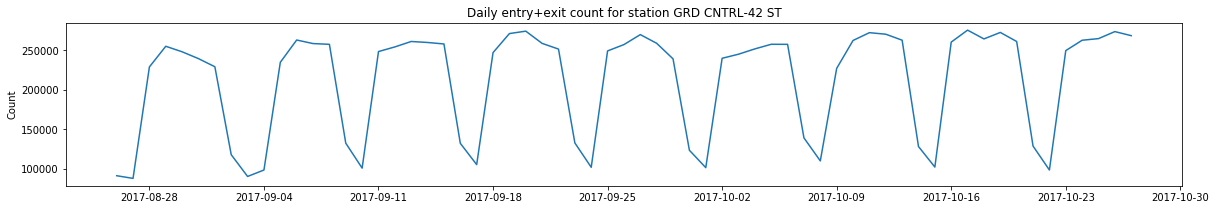

In [32]:
df['DAILY_RIDER_COUNT'] = df['DAILY_ENTRY_COUNT'] + df['DAILY_EXIT_COUNT']
fig, ax = plt.subplots(1,1, figsize=(20,3))
ax.plot(df['DATE'], df['DAILY_RIDER_COUNT']);
ax.set_title('Daily entry+exit count for station GRD CNTRL-42 ST');
ax.set_ylabel('Count');
ax.xaxis.set_major_locator(WeekdayLocator(byweekday=MO));
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'));

# look at the weekday/weekend traffic

**The median worker in the New York metropolitan area begins her workday at 8:24 a.m. There’s a buffer of about an hour on either side: 25 percent of the workforce has arrived by 7:28 a.m., while 75 percent has gotten in by 9:32.**

In [33]:
def getTimeType(timestamp):
    if (timestamp.hour >= dt.time(9).hour) & (timestamp.hour <= dt.time(12).hour): # includes 07:00 to 10:00
        return 'MORNING'
    elif (timestamp.hour >= dt.time(19).hour) & (timestamp.hour <= dt.time(21).hour): # include 16:00 to 19:00
        return 'EVENING'
    elif (timestamp.hour >= dt.time(1).hour) & (timestamp.hour <= dt.time(4).hour):
        return 'LATE'
    else:
        return 'OTHER'

In [34]:
# get the total entry counts for every station at every timestamp, 
# i.e, sum all the turnstile counts in a station at a timestamp
station_key = ['STATION_ID', 'DATETIME']
station_allturnstile_df = turnstile_df.groupby(station_key, sort=False, as_index=False)\
                                      [['ENTRY_COUNT', 'EXIT_COUNT']]\
                                      .agg('sum')
# get weekday
station_allturnstile_df['DOFW']     = station_allturnstile_df['DATETIME'].dt.weekday_name
station_allturnstile_df['DOFW_NUM'] = station_allturnstile_df['DATETIME'].dt.weekday
# classify as weekday/weekend
station_allturnstile_df['IS_WKDY'] = station_allturnstile_df['DOFW_NUM'].apply(lambda x: 0 if x>4 else 1)
# classify the time slot as morning/evening/late/other
station_allturnstile_df['TIME_TYPE'] = station_allturnstile_df['DATETIME'].apply(getTimeType)
# get date only
station_allturnstile_df['DATE'] = station_allturnstile_df['DATETIME'].dt.date

In [36]:
station_allturnstile_df['WKDY_COMMENTRY_COUNT'] = station_allturnstile_df['ENTRY_COUNT'] *\
                                                  station_allturnstile_df['IS_WKDY']*\
                                                  ((station_allturnstile_df['TIME_TYPE']=='MORNING')|\
                                                   (station_allturnstile_df['TIME_TYPE']=='EVENING'))
station_allturnstile_df['WKDY_COMMEXIT_COUNT']  = station_allturnstile_df['EXIT_COUNT'] *\
                                                  station_allturnstile_df['IS_WKDY']*\
                                                  ((station_allturnstile_df['TIME_TYPE']=='MORNING')|\
                                                   (station_allturnstile_df['TIME_TYPE']=='EVENING'))    

In [38]:
station_allturnstile_df.head()

,STATION_ID,DATETIME,ENTRY_COUNT,EXIT_COUNT,DOFW,DOFW_NUM,IS_WKDY,TIME_TYPE,DATE,WKDY_COMMENTRY_COUNT,WKDY_COMMEXIT_COUNT
0,1 AV_L,2017-08-26 04:00:00,1425.0,999.0,Saturday,5,0,LATE,2017-08-26,0.0,0.0
1,1 AV_L,2017-08-26 08:00:00,529.0,949.0,Saturday,5,0,OTHER,2017-08-26,0.0,0.0
2,1 AV_L,2017-08-26 12:00:00,2208.0,2516.0,Saturday,5,0,MORNING,2017-08-26,0.0,0.0
3,1 AV_L,2017-08-26 16:00:00,4076.0,3723.0,Saturday,5,0,OTHER,2017-08-26,0.0,0.0
4,1 AV_L,2017-08-26 20:00:00,3659.0,4603.0,Saturday,5,0,EVENING,2017-08-26,0.0,0.0


In [39]:
# finding total riders entering and exiting per station on each day of week over the entire time period
station_daily_count_df = station_allturnstile_df.groupby(['STATION_ID', 'DATE'], sort=False, as_index=False)\
                                    [['ENTRY_COUNT', 'WKDY_COMMENTRY_COUNT',
                                      'EXIT_COUNT', 'WKDY_COMMEXIT_COUNT']].agg(sum)

In [40]:
station_daily_count_df['DOFW_NUM'] = [x.weekday() for x in list(station_daily_count_df['DATE'])]
station_daily_count_df['IS_WKDY']  = station_daily_count_df['DOFW_NUM'].apply(lambda x: 0 if x>4 else 1)

In [41]:
station_daily_count_df.head()

,STATION_ID,DATE,ENTRY_COUNT,WKDY_COMMENTRY_COUNT,EXIT_COUNT,WKDY_COMMEXIT_COUNT,DOFW_NUM,IS_WKDY
0,1 AV_L,2017-08-26,11897.0,0.0,12790.0,0.0,5,0
1,1 AV_L,2017-08-27,13321.0,0.0,15576.0,0.0,6,0
2,1 AV_L,2017-08-28,16840.0,9843.0,18262.0,9613.0,0,1
3,1 AV_L,2017-08-29,18255.0,9685.0,19867.0,10211.0,1,1
4,1 AV_L,2017-08-30,19005.0,10470.0,20181.0,10444.0,2,1


In [42]:
# finding mean riders entering per weekday for each station over the entire time period
mean_wkdy_entries = station_daily_count_df.groupby('STATION_ID').\
                      apply(lambda x: (x['ENTRY_COUNT']*x['IS_WKDY']).sum()/x['IS_WKDY'].sum())
# finding mean riders exiting per weekday for each station over the entire time period
mean_wkdy_exits = station_daily_count_df.groupby('STATION_ID').\
                      apply(lambda x:(x['EXIT_COUNT']*x['IS_WKDY']).sum()/x['IS_WKDY'].sum())

In [43]:
# finding mean riders entering per weekend for each station over the entire time period
mean_wken_entries = station_daily_count_df.groupby('STATION_ID').\
                  apply(lambda x:(x['ENTRY_COUNT']*(1-x['IS_WKDY'])).sum()/(1-x['IS_WKDY']).sum())
# finding mean riders exiting per weekend for each station over the entire time period
mean_wken_exits = station_daily_count_df.groupby('STATION_ID').\
                  apply(lambda x:(x['EXIT_COUNT']*(1-x['IS_WKDY'])).sum()/(1-x['IS_WKDY']).sum())

In [44]:
# finding mean riders entering per weekday for each station during rush hour
mean_wkdy_commentries = station_daily_count_df.groupby('STATION_ID').\
                      apply(lambda x: (x['WKDY_COMMENTRY_COUNT']*x['IS_WKDY']).sum()/x['IS_WKDY'].sum())
# finding mean riders exiting per weekday for each station during rush hour
mean_wkdy_commexits = station_daily_count_df.groupby('STATION_ID').\
                      apply(lambda x:(x['WKDY_COMMEXIT_COUNT']*x['IS_WKDY']).sum()/x['IS_WKDY'].sum())

In [45]:
# finding mean riders per weekday and weekend for each station
mean_eachday_df = pd.concat([mean_wkdy_entries, mean_wkdy_exits, mean_wken_entries, mean_wken_exits,\
                             mean_wkdy_commentries, mean_wkdy_commexits], axis=1)
mean_eachday_df.columns = ['MEAN_WKDY_ENTRIES', 'MEAN_WKDY_EXITS', 'MEAN_WKEN_ENTRIES', 'MEAN_WKEN_EXITS',\
                           'MEAN_WKDY_COMM_ENTRIES', 'MEAN_WKDY_COMM_EXITS']
mean_eachday_df['MEAN_WKDY'] = (mean_eachday_df['MEAN_WKDY_ENTRIES'] + mean_eachday_df['MEAN_WKDY_EXITS'])/2
mean_eachday_df['MEAN_WKEN'] = (mean_eachday_df['MEAN_WKEN_ENTRIES'] + mean_eachday_df['MEAN_WKEN_EXITS'])/2
mean_eachday_df['MEAN_COMM_WKDY'] = (mean_eachday_df['MEAN_WKDY_COMM_ENTRIES'] 
                                     + mean_eachday_df['MEAN_WKDY_COMM_EXITS'])/2

In [46]:
# pick top stations based on total weekday traffic
ntop = 10
st_wkdymean_top_df = mean_eachday_df.nlargest(ntop, columns='MEAN_WKDY')          
print('Top stations based on mean weekday entry/exit traffic')
st_wkdymean_top_df

Top stations based on mean weekday entry/exit traffic


,MEAN_WKDY_ENTRIES,MEAN_WKDY_EXITS,MEAN_WKEN_ENTRIES,MEAN_WKEN_EXITS,MEAN_WKDY_COMM_ENTRIES,MEAN_WKDY_COMM_EXITS,MEAN_WKDY,MEAN_WKEN,MEAN_COMM_WKDY
STATION_ID,,,,,,,,,
GRD CNTRL-42 ST_4567S,126104.200000,126498.600000,56416.277778,55961.444444,65443.022222,62755.288889,126301.400000,56188.861111,64099.155556
34 ST-HERALD SQ_BDFMNQRW,108934.955556,96434.288889,67135.000000,56916.444444,59004.977778,56160.466667,102684.622222,62025.722222,57582.722222
14 ST-UNION SQ_456LNQRW,97909.933333,89454.555556,71950.888889,63150.722222,39164.977778,38053.044444,93682.244444,67550.805556,38609.011111
FULTON ST_2345ACJZ,92616.911111,75612.511111,38733.722222,28319.777778,52524.066667,42292.044444,84114.711111,33526.750000,47408.055556
TIMES SQ-42 ST_1237ACENQRSW,81492.177778,82381.822222,48301.555556,53157.611111,46250.244444,50862.800000,81937.000000,50729.583333,48556.522222
34 ST-PENN STA_ACE,79439.866667,66806.777778,41798.277778,40964.222222,45858.511111,40227.777778,73123.322222,41381.250000,43043.144444
42 ST-PORT AUTH_1237ACENQRSW,86666.044444,50407.822222,52175.333333,43945.055556,38641.866667,20807.200000,68536.933333,48060.194444,29724.533333
59 ST COLUMBUS_1ABCD,67063.466667,59646.555556,42615.000000,34090.166667,34004.533333,34712.422222,63355.011111,38352.583333,34358.477778
47-50 STS ROCK_BDFM,57291.911111,58354.666667,13188.000000,10681.000000,38376.644444,38613.755556,57823.288889,11934.500000,38495.200000


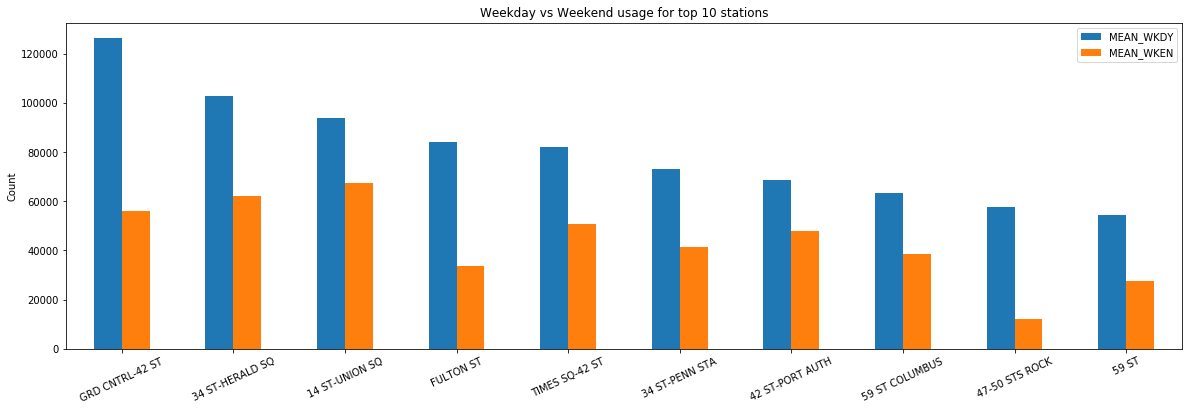

In [48]:
ax = st_wkdymean_top_df[['MEAN_WKDY','MEAN_WKEN']].plot(kind='bar', figsize=(20, 6));
fig = ax.get_figure()
ax.set_xticklabels([name[:name.index('_')] for name in st_wkdymean_top_df.index]);
plt.xlabel('');
plt.ylabel('Count');
plt.xticks(rotation=25)
plt.title('Weekday vs Weekend usage for top 10 stations');
#fig.savefig('Top10WeekdayStationsFinal.png', bbox_inches='tight')

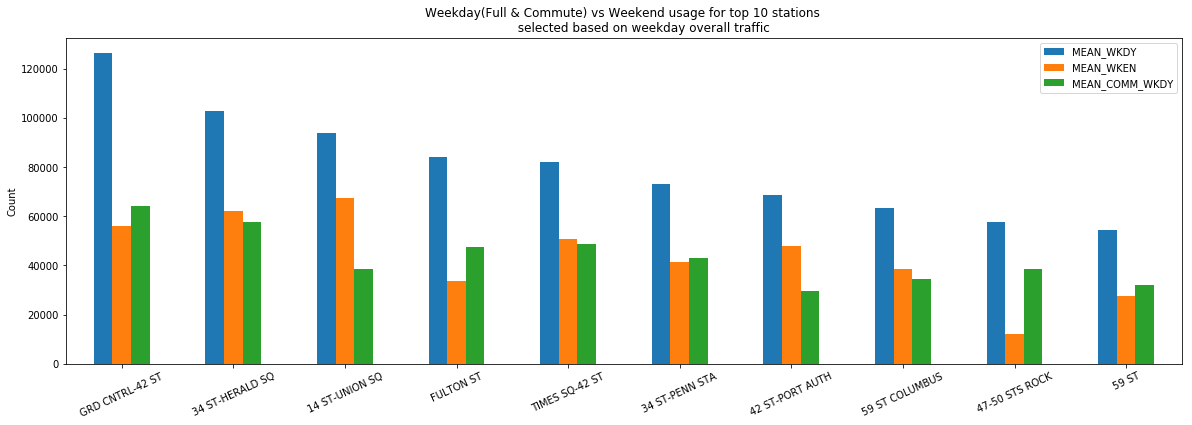

In [50]:
ax = st_wkdymean_top_df[['MEAN_WKDY','MEAN_WKEN','MEAN_COMM_WKDY']].plot(kind='bar', figsize=(20, 6));
fig = ax.get_figure()
ax.set_xticklabels([name[:name.index('_')] for name in st_wkdymean_top_df.index]);
plt.xlabel('');
plt.ylabel('Count');
plt.xticks(rotation=25);
plt.title('''Weekday(Full & Commute) vs Weekend usage for top 10 stations 
          selected based on weekday overall traffic''');

#fig.savefig('Top10Weekday_CommuteStationsFinal.png', bbox_inches='tight')

In [47]:
# pick top stations based on weekday rush hour traffic
ntop = 10
st_commwkdymean_top_df = mean_eachday_df.nlargest(ntop, columns='MEAN_COMM_WKDY')
print('Top stations based on mean weekday entry/exit traffic during rush hour')
st_commwkdymean_top_df

Top stations based on mean weekday entry/exit traffic during rush hour


,MEAN_WKDY_ENTRIES,MEAN_WKDY_EXITS,MEAN_WKEN_ENTRIES,MEAN_WKEN_EXITS,MEAN_WKDY_COMM_ENTRIES,MEAN_WKDY_COMM_EXITS,MEAN_WKDY,MEAN_WKEN,MEAN_COMM_WKDY
STATION_ID,,,,,,,,,
GRD CNTRL-42 ST_4567S,126104.200000,126498.600000,56416.277778,55961.444444,65443.022222,62755.288889,126301.400000,56188.861111,64099.155556
34 ST-HERALD SQ_BDFMNQRW,108934.955556,96434.288889,67135.000000,56916.444444,59004.977778,56160.466667,102684.622222,62025.722222,57582.722222
TIMES SQ-42 ST_1237ACENQRSW,81492.177778,82381.822222,48301.555556,53157.611111,46250.244444,50862.800000,81937.000000,50729.583333,48556.522222
FULTON ST_2345ACJZ,92616.911111,75612.511111,38733.722222,28319.777778,52524.066667,42292.044444,84114.711111,33526.750000,47408.055556
34 ST-PENN STA_ACE,79439.866667,66806.777778,41798.277778,40964.222222,45858.511111,40227.777778,73123.322222,41381.250000,43043.144444
14 ST-UNION SQ_456LNQRW,97909.933333,89454.555556,71950.888889,63150.722222,39164.977778,38053.044444,93682.244444,67550.805556,38609.011111
47-50 STS ROCK_BDFM,57291.911111,58354.666667,13188.000000,10681.000000,38376.644444,38613.755556,57823.288889,11934.500000,38495.200000
59 ST COLUMBUS_1ABCD,67063.466667,59646.555556,42615.000000,34090.166667,34004.533333,34712.422222,63355.011111,38352.583333,34358.477778
59 ST_456NQRW,57508.266667,51568.000000,29479.000000,25431.277778,34169.088889,29984.866667,54538.133333,27455.138889,32076.977778


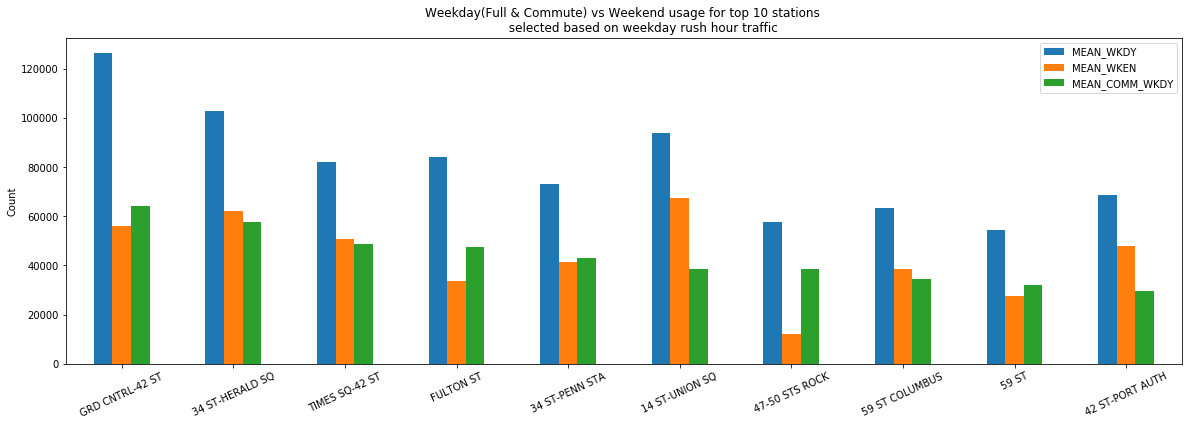

In [49]:
ax = st_commwkdymean_top_df[['MEAN_WKDY','MEAN_WKEN', 'MEAN_COMM_WKDY']].plot(kind='bar', figsize=(20, 6));
fig = ax.get_figure()
ax.set_xticklabels([name[:name.index('_')] for name in st_commwkdymean_top_df.index]);
plt.xlabel('');
plt.ylabel('Count');
plt.xticks(rotation=25)
plt.title('''Weekday(Full & Commute) vs Weekend usage for top 10 stations 
          selected based on weekday rush hour traffic''');
#fig.savefig('Top10CommuteWeekdayStationsFinal.png', bbox_inches='tight')

# Analyzing top 10 stations selected based on overall weekday traffic

In [51]:
# top stations for further analysis
top_stations = st_wkdymean_top_df.index
top_stations

Index(['GRD CNTRL-42 ST_4567S', '34 ST-HERALD SQ_BDFMNQRW',
       '14 ST-UNION SQ_456LNQRW', 'FULTON ST_2345ACJZ',
       'TIMES SQ-42 ST_1237ACENQRSW', '34 ST-PENN STA_ACE',
       '42 ST-PORT AUTH_1237ACENQRSW', '59 ST COLUMBUS_1ABCD',
       '47-50 STS ROCK_BDFM', '59 ST_456NQRW'],
      dtype='object', name='STATION_ID')

In [52]:
top_stations_df = pd.concat([turnstile_df.groupby('STATION_ID', sort=False, as_index=False).
                             get_group(group) for group in top_stations])

In [54]:
# get weekday
top_stations_df['DOFW'] = top_stations_df['DATETIME'].dt.weekday_name
top_stations_df['DOFW_NUM'] = top_stations_df['DATETIME'].dt.weekday
# classify as weekday/weekend
top_stations_df['IS_WKDY'] = top_stations_df['DOFW_NUM'].apply(lambda x: 0 if x>4 else 1)
# classify the time slot as morning/evening/late/other
top_stations_df['TIME_TYPE'] = top_stations_df['DATETIME'].apply(getTimeType)

In [55]:
top_stations_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DATE,TIME,DATETIME,STATION_ID,ENTRY_COUNT,EXIT_COUNT,DOFW,DOFW_NUM,IS_WKDY,TIME_TYPE
152277,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,2017-08-26,05:00:00,2017-08-26 05:00:00,GRD CNTRL-42 ST_4567S,4.0,6.0,Saturday,5,0,OTHER
152278,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,2017-08-26,09:00:00,2017-08-26 09:00:00,GRD CNTRL-42 ST_4567S,28.0,146.0,Saturday,5,0,MORNING
152279,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,2017-08-26,13:00:00,2017-08-26 13:00:00,GRD CNTRL-42 ST_4567S,110.0,364.0,Saturday,5,0,OTHER
152280,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,2017-08-26,17:00:00,2017-08-26 17:00:00,GRD CNTRL-42 ST_4567S,191.0,381.0,Saturday,5,0,OTHER
152281,R236,R045,00-00-00,GRD CNTRL-42 ST,4567S,2017-08-26,21:00:00,2017-08-26 21:00:00,GRD CNTRL-42 ST_4567S,134.0,223.0,Saturday,5,0,EVENING


## get the morning and evening rush hour traffic for the selected stations

In [56]:
def getWkdyMornCnt(row, wkdy, time, entry): 
    if entry:
        return row['ENTRY_COUNT']*(row['IS_WKDY']==wkdy)*(row['TIME_TYPE']==time)
    else:
        return row['EXIT_COUNT']*(row['IS_WKDY']==wkdy)*(row['TIME_TYPE']==time)

In [57]:
#get total morning entries on weekdays per day per station
top_stations_df['WKDY_MORN_ENTRY'] = top_stations_df.apply(getWkdyMornCnt, axis=1, wkdy=1, time='MORNING', entry=True)

In [58]:
#get total morning exits on weekdays per day per station
top_stations_df['WKDY_MORN_EXIT'] = top_stations_df.apply(getWkdyMornCnt, axis=1, wkdy=1, time='MORNING', entry=False)

In [59]:
#get total evening entries on weekdays per day per station
top_stations_df['WKDY_EVEN_ENTRY'] = top_stations_df.apply(getWkdyMornCnt, axis=1, wkdy=1, time='EVENING', entry=True)

In [60]:
#get total evening exits on weekdays per day per station
top_stations_df['WKDY_EVEN_EXIT'] = top_stations_df.apply(getWkdyMornCnt, axis=1, wkdy=1, time='EVENING', entry=False)

In [61]:
#get total morning entries on weekends per day per station
top_stations_df['WKEN_MORN_ENTRY'] = top_stations_df.apply(getWkdyMornCnt, axis=1, wkdy=0, time='MORNING', entry=True)

In [62]:
#get total morning exits on weekends per day per station
top_stations_df['WKEN_MORN_EXIT'] = top_stations_df.apply(getWkdyMornCnt, axis=1, wkdy=0, time='MORNING', entry=False)

In [63]:
#get total evening entries on weekends per day per station
top_stations_df['WKEN_EVEN_ENTRY'] = top_stations_df.apply(getWkdyMornCnt, axis=1, wkdy=0, time='EVENING', entry=True)

In [64]:
#get total evening exits on weekends per day per station
top_stations_df['WKEN_EVEN_EXIT'] = top_stations_df.apply(getWkdyMornCnt, axis=1, wkdy=0, time='EVENING', entry=False)

In [65]:
# get the aggregate of all turnstiles at a station per day
top_stations_agg_df = top_stations_df.groupby(['STATION_ID', 'DATE'], sort=False, as_index=False)\
                                     [['WKDY_MORN_ENTRY','WKDY_MORN_EXIT',\
                                       'WKDY_EVEN_ENTRY','WKDY_EVEN_EXIT',\
                                       'WKEN_MORN_ENTRY','WKEN_MORN_EXIT',\
                                       'WKEN_EVEN_ENTRY','WKEN_EVEN_EXIT']]\
                                     .agg(sum)

top_stations_agg_df['DOFW_NUM'] = [x.weekday() for x in list(top_stations_agg_df['DATE'])]
top_stations_agg_df['IS_WKDY'] = top_stations_agg_df['DOFW_NUM'].apply(lambda x: 0 if x>4 else 1)

top_stations_agg_df.head()

,STATION_ID,DATE,WKDY_MORN_ENTRY,WKDY_MORN_EXIT,WKDY_EVEN_ENTRY,WKDY_EVEN_EXIT,WKEN_MORN_ENTRY,WKEN_MORN_EXIT,WKEN_EVEN_ENTRY,WKEN_EVEN_EXIT,DOFW_NUM,IS_WKDY
0,GRD CNTRL-42 ST_4567S,2017-08-26,0.0,0.0,0.0,0.0,8743.0,9439.0,14362.0,13438.0,5,0
1,GRD CNTRL-42 ST_4567S,2017-08-27,0.0,0.0,0.0,0.0,6798.0,5953.0,13639.0,11419.0,6,0
2,GRD CNTRL-42 ST_4567S,2017-08-28,25752.0,32687.0,41197.0,25287.0,0.0,0.0,0.0,0.0,0,1
3,GRD CNTRL-42 ST_4567S,2017-08-29,25704.0,33652.0,44380.0,24961.0,0.0,0.0,0.0,0.0,1,1
4,GRD CNTRL-42 ST_4567S,2017-08-30,25219.0,33461.0,41036.0,26073.0,0.0,0.0,0.0,0.0,2,1


In [66]:
# get the aggregate for the entire time period for each station
top_stations_final_df = top_stations_agg_df.groupby('STATION_ID', sort=False)\
                                     [['WKDY_MORN_ENTRY','WKDY_MORN_EXIT',\
                                       'WKDY_EVEN_ENTRY','WKDY_EVEN_EXIT',\
                                       'WKEN_MORN_ENTRY','WKEN_MORN_EXIT',\
                                       'WKEN_EVEN_ENTRY','WKEN_EVEN_EXIT',\
                                       'IS_WKDY']].agg(sum)
                                     

top_stations_final_df.head()

,WKDY_MORN_ENTRY,WKDY_MORN_EXIT,WKDY_EVEN_ENTRY,WKDY_EVEN_EXIT,WKEN_MORN_ENTRY,WKEN_MORN_EXIT,WKEN_EVEN_ENTRY,WKEN_EVEN_EXIT,IS_WKDY
STATION_ID,,,,,,,,,
GRD CNTRL-42 ST_4567S,1105845.0,1614108.0,1839091.0,1209880.0,146741.0,165962.0,290438.0,253520.0,45
34 ST-HERALD SQ_BDFMNQRW,974428.0,1403283.0,1680796.0,1123938.0,130971.0,216346.0,390349.0,280436.0,45
14 ST-UNION SQ_456LNQRW,379121.0,869652.0,1383303.0,842735.0,35998.0,83966.0,397016.0,271361.0,45
FULTON ST_2345ACJZ,503248.0,1269826.0,1860335.0,633316.0,43467.0,62702.0,221021.0,124054.0,45
TIMES SQ-42 ST_1237ACENQRSW,493724.0,1325229.0,1587537.0,963597.0,91852.0,177808.0,252204.0,281464.0,45


In [67]:
top_stations_final_df.rename(columns={'IS_WKDY':'NUM_WKDY'}, inplace=True)
top_stations_final_df['NUM_WKEN'] = top_stations_agg_df.groupby('STATION_ID', sort=False).size() - \
                                    top_stations_final_df['NUM_WKDY']

In [68]:
# get the mean entry and exit counts
top_stations_final_df['WKDY_MORN_ENTRY'] /= top_stations_final_df['NUM_WKDY']
top_stations_final_df['WKDY_MORN_EXIT'] /= top_stations_final_df['NUM_WKDY']
top_stations_final_df['WKDY_EVEN_ENTRY'] /= top_stations_final_df['NUM_WKDY']
top_stations_final_df['WKDY_EVEN_EXIT'] /= top_stations_final_df['NUM_WKDY']

top_stations_final_df['WKEN_MORN_ENTRY'] /= top_stations_final_df['NUM_WKEN']
top_stations_final_df['WKEN_MORN_EXIT'] /= top_stations_final_df['NUM_WKEN']
top_stations_final_df['WKEN_EVEN_ENTRY'] /= top_stations_final_df['NUM_WKEN']
top_stations_final_df['WKEN_EVEN_EXIT'] /= top_stations_final_df['NUM_WKEN']

In [69]:
top_stations_final_df

,WKDY_MORN_ENTRY,WKDY_MORN_EXIT,WKDY_EVEN_ENTRY,WKDY_EVEN_EXIT,WKEN_MORN_ENTRY,WKEN_MORN_EXIT,WKEN_EVEN_ENTRY,WKEN_EVEN_EXIT,NUM_WKDY,NUM_WKEN
STATION_ID,,,,,,,,,,
GRD CNTRL-42 ST_4567S,24574.333333,35869.066667,40868.688889,26886.222222,8152.277778,9220.111111,16135.444444,14084.444444,45,18
34 ST-HERALD SQ_BDFMNQRW,21653.955556,31184.066667,37351.022222,24976.400000,7276.166667,12019.222222,21686.055556,15579.777778,45,18
14 ST-UNION SQ_456LNQRW,8424.911111,19325.600000,30740.066667,18727.444444,1999.888889,4664.777778,22056.444444,15075.611111,45,18
FULTON ST_2345ACJZ,11183.288889,28218.355556,41340.777778,14073.688889,2414.833333,3483.444444,12278.944444,6891.888889,45,18
TIMES SQ-42 ST_1237ACENQRSW,10971.644444,29449.533333,35278.600000,21413.266667,5102.888889,9878.222222,14011.333333,15636.888889,45,18
34 ST-PENN STA_ACE,23548.977778,17172.888889,22309.533333,23054.888889,6775.500000,8661.833333,12444.777778,11338.555556,45,18
42 ST-PORT AUTH_1237ACENQRSW,26632.800000,10334.533333,12009.066667,10472.666667,8644.111111,7629.944444,8709.944444,8387.777778,45,18
59 ST COLUMBUS_1ABCD,11134.955556,22246.466667,22869.577778,12465.955556,5402.777778,7682.444444,13926.222222,8731.888889,45,18
47-50 STS ROCK_BDFM,3408.444444,32252.044444,34968.200000,6361.711111,1052.111111,2528.388889,4031.888889,2657.666667,45,18


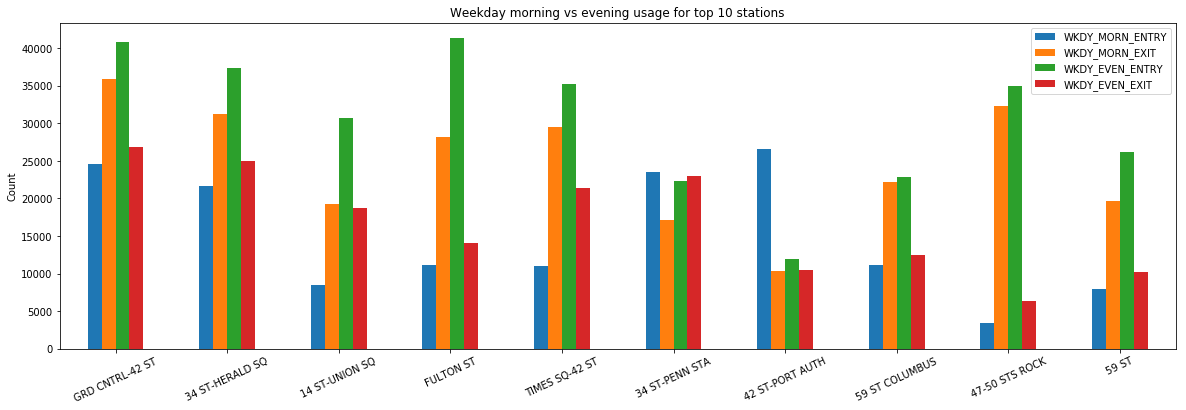

In [70]:
ax = top_stations_final_df[['WKDY_MORN_ENTRY','WKDY_MORN_EXIT','WKDY_EVEN_ENTRY','WKDY_EVEN_EXIT']].\
                plot(kind='bar', figsize=(20, 6));
fig = ax.get_figure()
ax.set_xticklabels([name[:name.index('_')] for name in top_stations_final_df.index]);
plt.xticks(rotation=25)
plt.xlabel('');
plt.ylabel('Count');
plt.title('Weekday morning vs evening usage for top 10 stations');
#fig.savefig('Top10WeekdayTraffic.png', bbox_inches='tight')

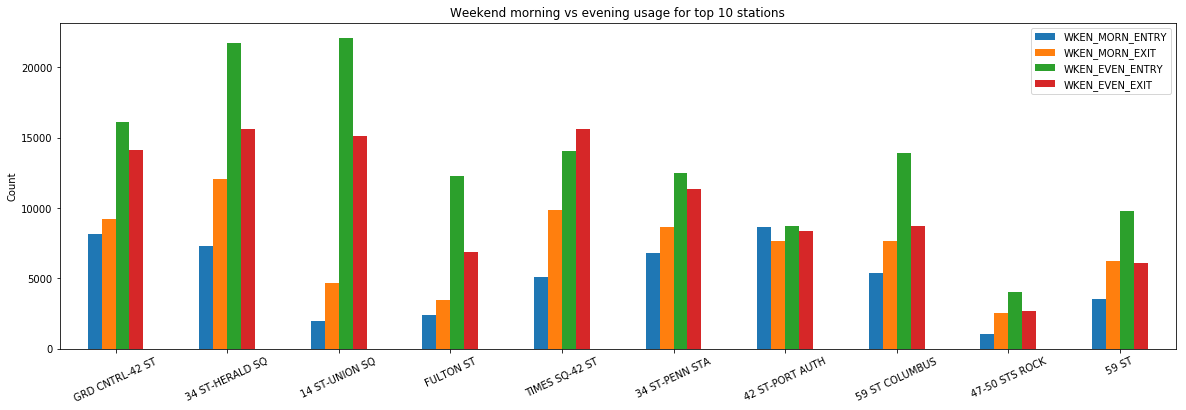

In [71]:
ax = top_stations_final_df[['WKEN_MORN_ENTRY','WKEN_MORN_EXIT','WKEN_EVEN_ENTRY','WKEN_EVEN_EXIT']].\
                plot(kind='bar', figsize=(20, 6));
fig = ax.get_figure()
ax.set_xticklabels([name[:name.index('_')] for name in top_stations_final_df.index]);
plt.xticks(rotation=25)
plt.xlabel('');
plt.ylabel('Count');
plt.title('Weekend morning vs evening usage for top 10 stations');
#fig.savefig('Top10WeekendTraffic.png', bbox_inches='tight')

**47th–50th Streets–Rockefeller Center and Fulton Street have high morning exits and high evening entries on weekdays, which implies they are in neighborhoods with lots of offices**

In [104]:
# selecting 47th–50th Streets–Rockefeller Center turnstile data
station1_dayofweek = (top_stations_df[(top_stations_df['STATION_ID']=='47-50 STS ROCK_BDFM')]
                      .groupby('DOFW', sort=False, as_index=False)
                      [['ENTRY_COUNT', 'EXIT_COUNT']]
                      .agg(sum))
station1_timeofday = (top_stations_df[((top_stations_df['STATION_ID']=='47-50 STS ROCK_BDFM')
                                       &(top_stations_df['IS_WKDY']==1))]
                      .groupby('TIME', sort=False, as_index=False)
                      [['ENTRY_COUNT', 'EXIT_COUNT']]
                      .agg(sum))
station1_timeofday.sort_values(by='TIME', inplace=True)

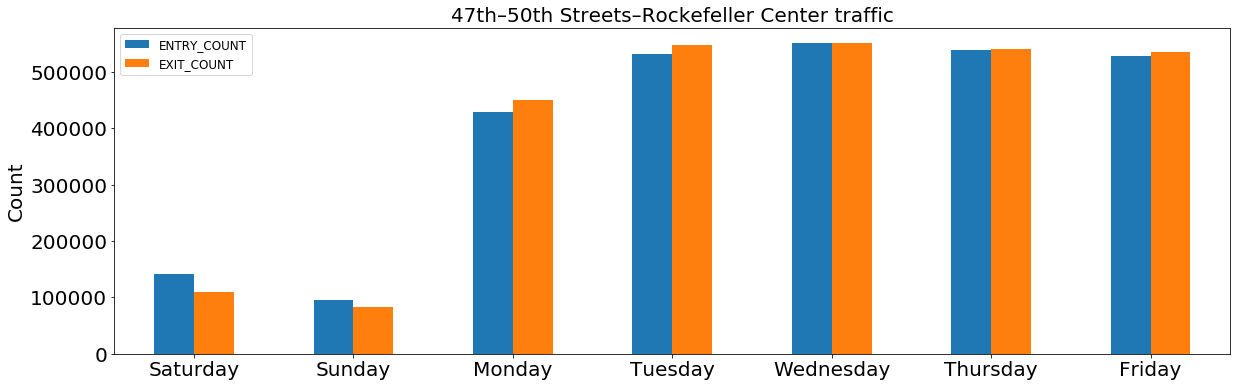

In [93]:
ax = station1_dayofweek.plot(x='DOFW', kind='bar', figsize=(20, 6), rot=0, fontsize=20);
#ax.set(xlabel='Day of Week', ylabel='Count');
ax.set_title('47th–50th Streets–Rockefeller Center traffic', fontsize = 20)
ax.set_xlabel('', fontsize = 20);
ax.set_ylabel('Count', fontsize = 20);

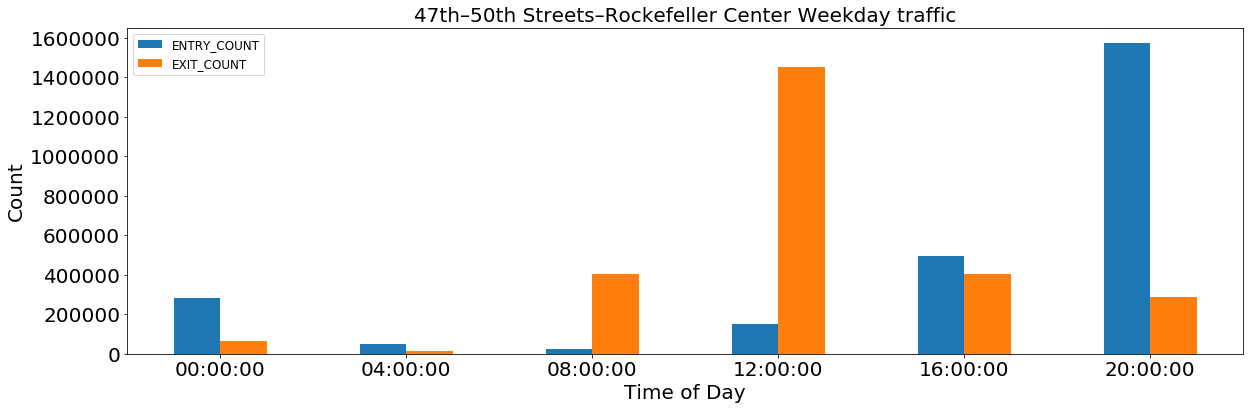

In [106]:
ax = station1_timeofday.plot(x='TIME', kind='bar', figsize=(20, 6), rot=0, fontsize=20);
#ax.set(xlabel='Time of Day', ylabel='Count');
ax.set_title('47th–50th Streets–Rockefeller Center Weekday traffic', fontsize = 20)
ax.set_xlabel('Time of Day', fontsize = 20);
ax.set_ylabel('Count', fontsize = 20);

**This station has high exit count in the mornings and high entry count in the evening on weekdays. This implies it is close to a office neighborhood**

In [110]:
# selecting Fulton Street turnstile data
station2_dayofweek = (top_stations_df[(top_stations_df['STATION_ID']=='FULTON ST_2345ACJZ')]
                      .groupby('DOFW', sort=False, as_index=False)
                      [['ENTRY_COUNT', 'EXIT_COUNT']]
                      .agg(sum))
station2_timeofday = (top_stations_df[((top_stations_df['STATION_ID']=='FULTON ST_2345ACJZ')
                                       &(top_stations_df['IS_WKDY']==1))]
                      .groupby('TIME', sort=False, as_index=False)
                      [['ENTRY_COUNT', 'EXIT_COUNT']]
                      .agg(sum))
station2_timeofday.sort_values(by='TIME', inplace=True)

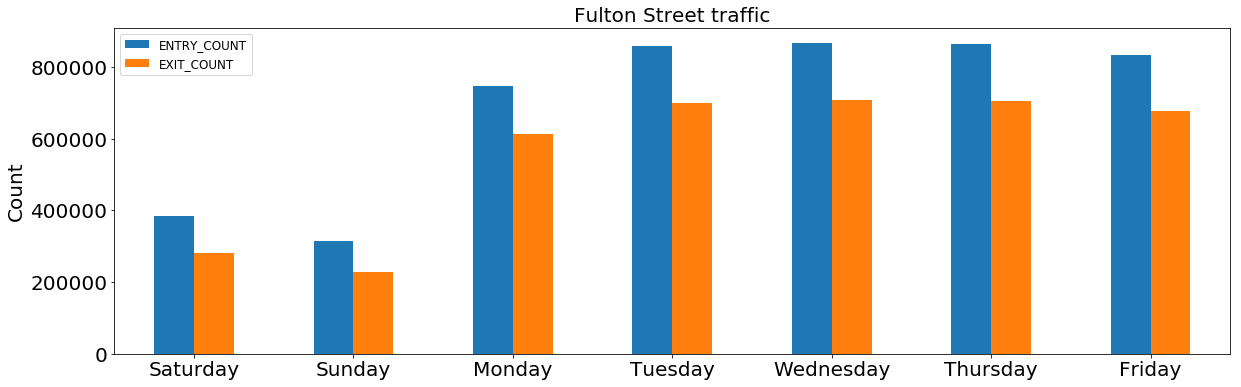

In [95]:
ax = station2_dayofweek.plot(x='DOFW', kind='bar', figsize=(20, 6), rot=0, fontsize=20);
#ax.set(xlabel='Day of Week', ylabel='Count');
ax.set_title('Fulton Street traffic', fontsize = 20)
ax.set_xlabel('', fontsize = 20);
ax.set_ylabel('Count', fontsize = 20);

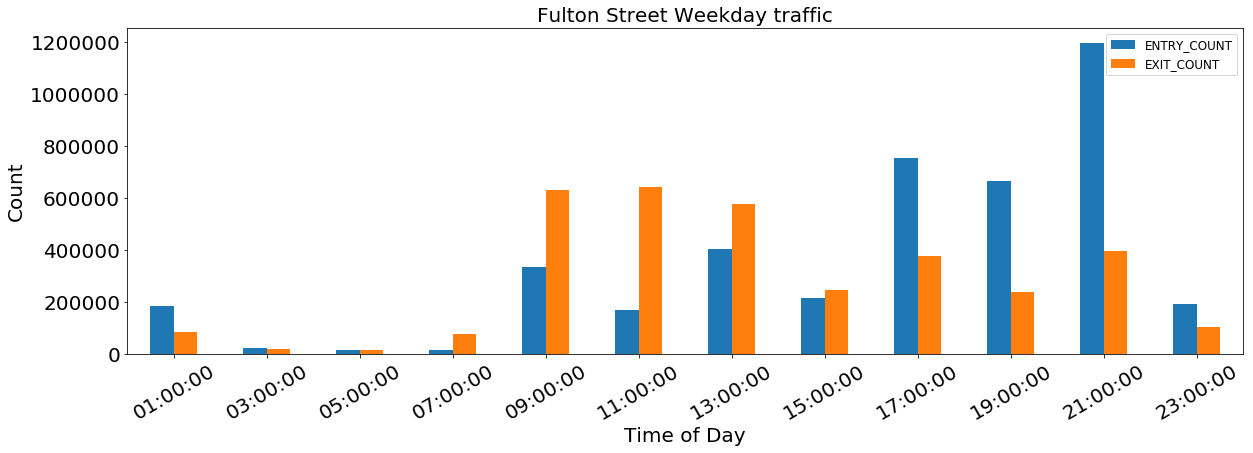

In [112]:
ax = station2_timeofday.plot(x='TIME', kind='bar', figsize=(20, 6), rot=30, fontsize=20);
ax.set_title('Fulton Street Weekday traffic', fontsize = 20)
ax.set_xlabel('Time of Day', fontsize = 20);
ax.set_ylabel('Count', fontsize = 20);

**This station has high exit count in the mornings and high entry count in the evening on weekdays. This implies it is close to a office neighborhood**